# Solution: Fast LightGBM with Feature Engineering

This approach applies **custom feature engineering** to enrich the dataset, then trains a **LightGBM regression model** using **5-fold cross-validation** with GPU acceleration for efficiency. It uses **carefully tuned hyperparameters** (low learning rate, higher leaves, regularization terms) to balance accuracy and generalization.  

The process generates:  
- **Out-of-fold (OOF) predictions** for reliable CV scoring  
- **Aggregated test predictions** for submission  
- **Feature importance analysis** to interpret the model  
- **Final CV RMSE score** for performance benchmarking  

Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[209]	valid_0's rmse: 26.4382
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[155]	valid_0's rmse: 26.4836
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[164]	valid_0's rmse: 26.5253
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[238]	valid_0's rmse: 26.4442
Training until validation scores don't improve for 300 rounds
Early stopping, best iteration is:
[311]	valid_0's rmse: 26.408
Fast LightGBM CV RMSE: 26.45990
Fold Scores Std: 0.04062
Tuned LightGBM Final Score: 26.45990
Tuned LightGBM model completed!


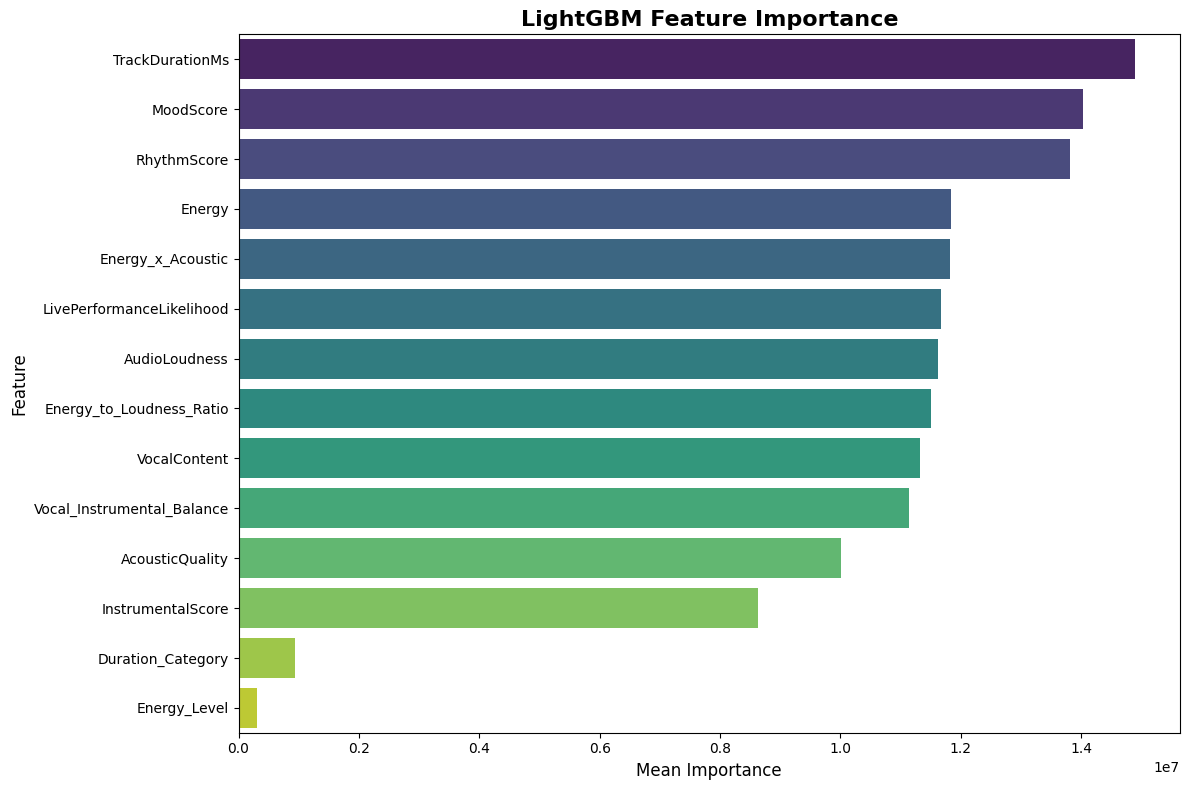

In [8]:
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering
train_fe = add_features(train.copy())
test_fe = add_features(test.copy())

# Separate features and target
X = train_fe.drop(columns=['BeatsPerMinute', 'id'])
y = train_fe['BeatsPerMinute']
X_test = test_fe.drop(columns=['BeatsPerMinute', 'id'], errors='ignore')  # In case test has no target

def train_lightgbm_fast(X, y, X_test):
    best_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,     
        'num_leaves': 128,          
        'max_depth': -1,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'min_child_samples': 20,
        'lambda_l1': 1.0,
        'lambda_l2': 10.0,
        'device': 'gpu',             # Use GPU if available
        'n_jobs': -1,
        'verbosity': -1
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(X))
    test_preds = np.zeros(len(X_test))
    fold_scores = []
    feature_importances = pd.DataFrame(index=X.columns)

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        model = lgb.train(
            best_params,
            train_data,
            valid_sets=[val_data],
            num_boost_round=5000,
            callbacks=[
                lgb.early_stopping(300),
                lgb.log_evaluation(1000)
            ]
        )

        val_pred = model.predict(X_val, num_iteration=model.best_iteration)
        test_pred = model.predict(X_test, num_iteration=model.best_iteration)

        oof_preds[val_idx] = val_pred
        test_preds += test_pred / 5

        fold_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        fold_scores.append(fold_rmse)
        feature_importances[f'Fold_{fold+1}'] = model.feature_importance(importance_type='gain')

    cv_score = np.sqrt(mean_squared_error(y, oof_preds))
    feature_importances['Mean_Importance'] = feature_importances.mean(axis=1)
    feature_importances = feature_importances.sort_values(by='Mean_Importance', ascending=False)

    print(f"Fast LightGBM CV RMSE: {cv_score:.5f}")
    print(f"Fold Scores Std: {np.std(fold_scores):.5f}")
    return oof_preds, test_preds, cv_score, feature_importances

# Train the fast LightGBM model
tuned_lgb_oof, tuned_lgb_test, tuned_lgb_score, feature_importance = train_lightgbm_fast(X, y, X_test)

# Prepare submission
submission = pd.DataFrame({
    'id': test['id'],              # Make sure test['id'] exists
    'BeatsPerMinute': tuned_lgb_test
})

submission.to_csv('submission.csv', index=False)

print(f"Tuned LightGBM Final Score: {tuned_lgb_score:.5f}")
print("Tuned LightGBM model completed!")

# Plot a graph for Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Mean_Importance',
    y=feature_importance.index,
    hue=feature_importance.index,   # map feature names to hue
    dodge=False,
    legend=False,
    data=feature_importance,
    palette="viridis"
)
plt.title('LightGBM Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Mean Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()